# heterograph: graph operations

## neighbour ordering

When capturing programming models, it is often crucial to preserve the order of incoming or outgoing edges. For example, maintaining the order is essential for parameter lists or statement lists. When using `add_edge`, the insertion order determines the neighbor ordering.

### implicit ordering

In [1]:
from heterograph import *
g = HGraph()
g.add_vx(4)
g.add_edge(0, [3, 1, 2])
g.out_vx(0)

[3, 1, 2]

### custom ordering

The methods `in_vx(vx)` and `out_vx(vx)` include three optional parameters to configure the ordering:

- `order` (list of int): A list of vertex IDs specifying the desired order. This list can be a subset of the neighbors.
- `anchor` (int, default: None): A vertex ID indicating where to insert the subset provided in `order`. If the anchor is `None`, the subset is inserted at the end of the list.
- `after` (bool, default: True): Determines whether to insert the sublist before or after the anchor.

In [2]:
g=HGraph()
g.add_vx(5)
g.add_edge(0, [1, 2, 3, 4])
g.out_vx(0)

[1, 2, 3, 4]

In [3]:
# specify the order [2, 1, 3, 4]
g.out_vx(0, order=[2, 1, 3, 4])

[2, 1, 3, 4]

In [4]:
# specify subset [3, 2] (by default after the last element)
g.out_vx(0, order=[3,2])

[1, 4, 3, 2]

In [5]:
# specify subset before [3, 2] before 4
g.out_vx(0, order=[3,2], after=False, anchor=4)

[1, 3, 2, 4]

## cloning a graph

To clone a graph, we use the `copy(vs=None, g=None, induced=True, ret_map=False)` method, which offers the following optional parameters:

- `vs`: A list of IDs specifying which vertices should be included in the copy. If not provided, all vertices will be copied.
- `g`: If supplied, vertices will be copied and added to the specified graph `g`. Otherwise, a new graph is created.
- `induced`: If set to True, any edge between two copied vertices will also be copied, allowing for the cloning of a subgraph.
- `ret_map`: If True, the method returns a tuple `(cg, map)`, where `cg` is the graph where vertices were copied, and `map` provides a mapping from old to new vertices in the form of a dictionary `{old vertex: new vertex}`.


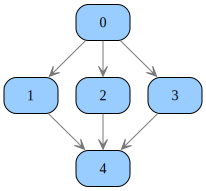

In [6]:
g=HGraph()
g.add_vx(5)
g.add_edge(0, [1, 2, 3])
g.add_edge([1,2,3], 4)
g.view()

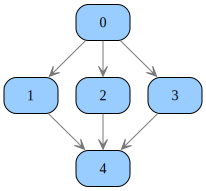

In [7]:
# clone the whole graph
h = g.copy()
h.view()

{0: 0, 2: 1, 4: 2}


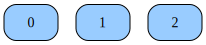

In [8]:
# clone only vertices
(h, rmap) = g.copy(vs=[0, 2, 4], induced=False, ret_map=True)
print(rmap)
h.view()

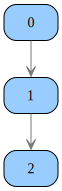

In [9]:
# clone subgraph (induced)
h = g.copy(vs=[0, 2, 4])
h.view()

{0: 5, 2: 6, 4: 7}


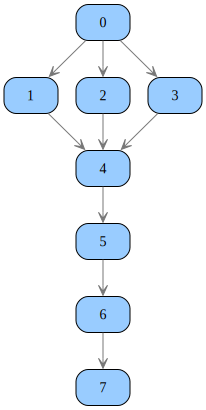

In [10]:
# clone full graph
h1 = g.copy()
# clone subgraph into graph h1
(h2, rmap) = g.copy(vs=[0, 2, 4], g=h1, ret_map=True)
print(rmap)
# connect first copy with second copy
h2.add_edge(4, 5)
h2.view()

## depth-first search (DFS) 

DFS, or Depth-First Search, is an algorithm for traversing or searching tree or graph data structures. The algorithm starts at the root (selecting some arbitrary node as the root in the case of a graph) and explores as far as possible along each branch before backtracking. 

Let us look at the following example:

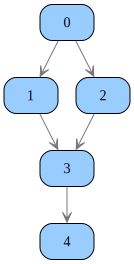

In [11]:
from heterograph import *
g = HGraph()
g.add_vx(5)
g.add_edge(0, [1, 2])
g.add_edge([1,2], 3)
g.add_edge(3, 4)
g.view()

### collecting all paths
To gather all paths, we utilize the function `get_paths(g, vs=None)`:
* if vs is not provided (default), then all source vertices in the graph (vertices without inputs) are taken into account.

In [12]:
from heterograph.algorithm.dfs import get_paths
get_paths(g) # root is 0 (graph source)

[[0, 1, 3, 4], [0, 2, 3, 4]]

In [13]:
get_paths(g, vs=[1, 2]) # root: 1 and 2

[[1, 3, 4], [2, 3, 4]]

### visiting nodes
To visit all nodes of a graph using depth-first search, you can use `dfs_visitor(g, vs=None, pre=None, post=None, data=None)` function: 
* `g` (HGraph): The graph to perform the depth-first search on.
* `vs` (list, optional): The starting vertices for the search. If not provided, the source vertices of the graph will be used.
* `pre` (function, optional): A function to be called before visiting each vertex. It takes four arguments: the graph, the current vertex, the current path, and the additional data.
* `post` (function, optional): A function to be called after visiting each vertex. It takes four arguments: the graph, the current vertex, the current path, and the additional data.
* `data` (any, optional): Additional data to be passed to the pre and post functions. 

Note: functions `pre` or `post` can gracefully stop search at any time by raising `StopSearch`.

In [14]:
from heterograph.algorithm.dfs import dfs_visitor, StopSearch
def pre(g, vx, path, data):
    counter = data['n']
    print(f"Hello vertex {vx}: {counter}")
    data['n'] = counter + 1

def post(g, vx, path, data):
    print(f"Bye vertex {vx}")

def pre_stops_at_3(g, vx, path, data):
    print(f"Hello again vertex {vx}")
    if vx == 3:
        raise StopSearch()

counter = { 'n': 0 }
# pass data as reference instead of value in order to change it
dfs_visitor(g, [0], pre=pre, post=post, data=counter)
print("===")
dfs_visitor(g, [0], pre=pre_stops_at_3)


Hello vertex 0: 0
Hello vertex 1: 1
Hello vertex 3: 2
Hello vertex 4: 3
Bye vertex 4
Bye vertex 3
Bye vertex 1
Hello vertex 2: 4
Hello vertex 3: 5
Hello vertex 4: 6
Bye vertex 4
Bye vertex 3
Bye vertex 2
Bye vertex 0
===
Hello again vertex 0
Hello again vertex 1
Hello again vertex 3


### graph traversal

The `dfs_traversal(g, vx, pre=None, post=None, inh=None)` function provides an advanced mechanism for depth-first search (DFS) traversal:

* It is more efficient than `dfs_visitor`, making it ideal for large graphs.
* The `inh` parameter allows you to pass initial data that can be inherited by the child nodes during traversal.
* If supplied, the `pre(g, vx, inh)` function is invoked prior to the visitation of `vx`. The `inh` parameter is optional and represents the value inherited from the parent node.
* If supplied, the `post(g, vx, synth)` function is invoked following the visitation of `vx`. The `synth` parameter is optional and represents a list of values, each of which is returned by a child node.

In the example below, we use the inheritance feature to assign a depth to each vertex and the synthesis feature to count the number of vertices visited.

In [15]:
from heterograph.algorithm.dfs import dfs_traversal

def pre_visit(g, vx, inh):
    print(f"Pre-visit: {vx}, inherited: {inh}")
    return inh + 1

def post_visit(g, vx, synth):
    print(f"Post-visit: {vx}, synthesized: {synth}")
    return sum(synth) + 1

dfs_traversal(g, 0, pre=pre_visit, post=post_visit, inh=0)

Pre-visit: 0, inherited: 0
Pre-visit: 1, inherited: 1
Pre-visit: 3, inherited: 2
Pre-visit: 4, inherited: 3
Post-visit: 4, synthesized: []
Post-visit: 3, synthesized: [1]
Post-visit: 1, synthesized: [2]
Pre-visit: 2, inherited: 1
Post-visit: 2, synthesized: [2]
Post-visit: 0, synthesized: [3, 3]


7

## erasing a graph

To remove parts of the graph, we use the `remove_subgraph(vx)` method, where `vx` is the root vertex of the subgraph. All graph elements connected directly and indirectly to `vx` are removed. 


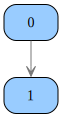

In [16]:
# from the graph above
g.remove_subgraph(2)
g.view()

To remove all graph elements and reset the graph, we can use the method `erase()`.